# Lab4. Training, Deploying and hosting custom model on SageMaker

In this lab, you will run your training job with SageMaker. You will use your CNN architecture and script that you build at Lab3. 

 ## Set up SageMaker environment

* **Plase note that the Tensorflow eager mode will be enabled by below code:**  
 tf.enable_eager_execution()

In [1]:
from PIL import Image
import json
import os
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe
from sagemaker.tensorflow import TensorFlow

tf.enable_eager_execution()

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20180531T094549
CPU times: user 92 ms, sys: 478 µs, total: 92.5 ms
Wall time: 119 ms


## Upload data to S3

* **Make sure you change the bucket name None with your S3 bucket name**


In [3]:
bucket = None #'leonkang-datalake-nv' # custom bucket name.
prefix = 'anpr'
assert bucket != None

* Upload files to S3
* It may take several minutes **(10~15 minutes for 10,000 images)**

In [4]:
%%time

train_channel = prefix + '/tf/tf-train'
validation_channel = prefix + '/tf/tf-validation'
train_annotation_channel = prefix + '/tf/tf-train_annotation'
validation_annotation_channel = prefix + '/tf/tf-validation_annotation'

sess.upload_data(path='tf/tf-train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='tf/tf-validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='tf/tf-train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='tf/tf-validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 1min 53s, sys: 7.55 s, total: 2min 1s
Wall time: 14min 37s


* Check upload results 

In [5]:
!aws s3 ls {bucket}/anpr/od/od-train/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-train_annotation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation_annotation/ |wc -l

8000
8000
2000
2000


In [6]:
s3_output_location = 's3://{}/{}/tf-output'.format(bucket, prefix)

## Run training job on SageMaker

Training data will be copied from S3 to Tensorflow container.  
Refer to the below directory paths.

### Test and validation data directories
1) In this notebook
- train images: './tf/tf-train'
- train annotations: './tf/tf-train_annotations'
- validation images: './tf/tf-validation'
- validation annotations: './tf/tf-validation_annotations'

2) S3
- train images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train'
- train annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation'
- validation images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train_annotations'
- validation annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation_annotations'

**3) Training container (Tensorflow container)**
- **train images: '/opt/ml/input/data/train/'**
- **train annotations: '/opt/ml/input/data/train_annotation/'**
- **validation images: '/opt/ml/input/data/validation/'**
- **validation annotations: '/opt/ml/input/data/validation_annotation/'**

In [8]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

* **This time, we will run 30 epochs to build more accurate model. (It may take less than 10 minutes)**
* Note that we use p3.16xlarge instance, which will shorten our training time
* Refer to API specs of SDK site
    * https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst
    * https://sagemaker.readthedocs.io/en/latest/using_tf.html
* Refer to the API document 
    * https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html  
   (Note that checkpoint_path, training_steps, evaluation_steps, requirements_file args are not permitted when using Script Mode)

* **Check the code of 'cnn_ocr.py' file**
    * Notice the hyperparameters are parsed from argparse.ArgumentParser()
    * Notice the model function is same as Lab3
    * In the main function, input data are loaded from local directory 'opt/ml/data/{...channel...}'

In [9]:
!cat cnn_ocr.py

import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers import concatenate
import os
import argparse

import json
from PIL import Image

import keras.backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf

from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()
tf.set_random_seed(0)

NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '

In [14]:
model_dir = '/opt/ml/model'
train_instance_type='ml.p3.16xlarge'
hyperparameters = {'epochs': 30, 
                   'batch_size': 128,
                   'learning_rate': 0.001}

In [ ]:
%%time
ocr_estimator = TensorFlow(entry_point='cnn_ocr.py',
                             role=role,
                             model_dir=model_dir,
                             hyperparameters=hyperparameters,
                             train_instance_count=2,
                             train_instance_type=train_instance_type,
                             distributions={'parameter_server': {'enabled': True}},
#                              distributions={
#                                   'mpi': {
#                                       'enabled': True,
#                                       'processes_per_host': 8,
#                                       'custom_mpi_options': '--NCCL_DEBUG INFO'
#                                   }
#                              }),
                             framework_version='1.12', 
                             py_version='py3')

ocr_estimator.fit(data_channels)

* Check the model name that training job just created
* Check the model file that training job just created

In [26]:
print(ocr_estimator.output_path)
print(ocr_estimator.model_data)

!aws s3 ls {ocr_estimator.model_data}

s3://sagemaker-us-east-1-308961792850/
s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-03-09-00-23-00-877/output/model.tar.gz
2019-03-09 00:34:47   75768194 model.tar.gz


## Test data

* Prepare character list and test images

In [17]:
import numpy as np

In [18]:
NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

In [19]:
test_imgs = os.listdir('tf/tf-validation')

## Test the trainned model in local

* Copy trainned model from S3 to ./model folder

In [21]:
#!rm -Rf model
!aws s3 cp {ocr_estimator.model_data} ./model/model.tar.gz --region us-east-1

download: s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-03-09-00-23-00-877/output/model.tar.gz to model/model.tar.gz


* Extract the model file and see the components

In [22]:
!tar -xvzf ./model/model.tar.gz -C ./model

1552091667/
1552091667/variables/
1552091667/variables/variables.index
1552091667/variables/variables.data-00000-of-00001
1552091667/variables/checkpoint
1552091667/assets/
1552091667/assets/saved_model.json
1552091667/saved_model.pb
weights.ckpt.data-00000-of-00001
weights.ckpt.index
checkpoint
weights.ckpt.index
weights.ckpt.data-00000-of-00001
checkpoint
1552091672/
1552091672/assets/
1552091672/assets/saved_model.json
1552091672/saved_model.pb
1552091672/variables/
1552091672/variables/variables.data-00000-of-00001
1552091672/variables/variables.index
1552091672/variables/checkpoint


* Define model architecture locally (same as Lab3)

In [23]:
import matplotlib.pyplot as plt
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

* Read and retore model from downloaded checkpoint

In [24]:
tf.keras.backend.clear_session()
device = '/cpu:0' 

with tf.device(device):    
    local_model = model((128,64,1))
    saver = tfe.Saver(local_model.variables)
    saver.restore('model/weights.ckpt')

INFO:tensorflow:Restoring parameters from model/weights.ckpt


INFO:tensorflow:Restoring parameters from model/weights.ckpt


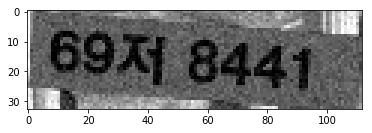

['6', '9', '저', '3', '4', '4', '1']


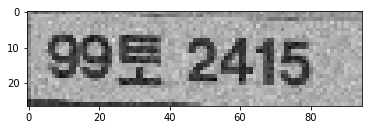

['9', '9', '토', '2', '4', '1', '5']


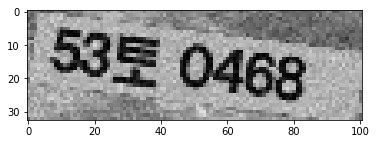

['5', '8', '토', '0', '4', '6', '8']


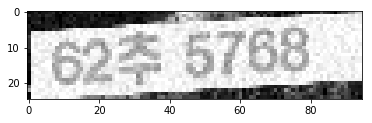

['7', '2', '추', '5', '7', '6', '8']


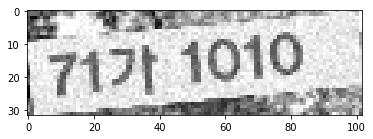

['7', '1', '거', '1', '0', '1', '0']


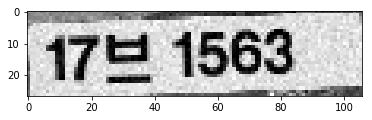

['1', '7', '브', '1', '6', '6', '3']


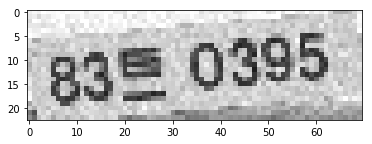

['8', '3', '트', '0', '3', '9', '5']


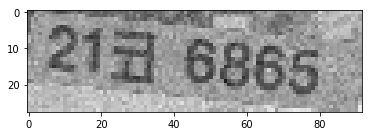

['3', '1', '코', '6', '8', '8', '9']


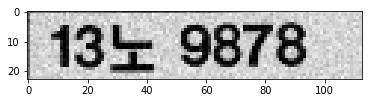

['1', '7', '노', '9', '8', '7', '8']


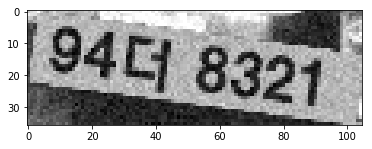

['9', '4', '터', '6', '3', '2', '2']


In [28]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    prediction = local_model.predict(val_img_np.reshape([1,128,64,1])/255.)
    plt.imshow(val_img)
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][0])], 
              JOIN[np.argmax(prediction[1][0])], 
              JOIN[np.argmax(prediction[2][0])], 
              JOIN[np.argmax(prediction[3][0])], 
              JOIN[np.argmax(prediction[4][0])], 
              JOIN[np.argmax(prediction[5][0])], 
              JOIN[np.argmax(prediction[6][0])]]
    print(digits)

* You may utilize above code to build your own inference environment
* You can find that the accuracy of our model is increased slightly
* We may further refine our model in the following ways:
    * Adding more training images and more epochs
    * Adding real world license plate images
    * Changing an architecture to another structure (ex: CNN + LSTM)

## Deploy the model and inference Test

* Now, let's deploy our model into SageMaker's inference hosting environment 

In [31]:
predictor = ocr_estimator.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge',
                                 accelerator_type='ml.eia1.medium')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2019-03-09-00-23-00-877
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2019-03-09-00-23-00-877


----------------------------------------------------------------!

* Check the result of deploy

In [54]:
predictor

In [32]:
predictor.endpoint

'sagemaker-tensorflow-scriptmode-2019-03-09-00-23-00-877'

* Check the prediction of 10 sample pairs of images

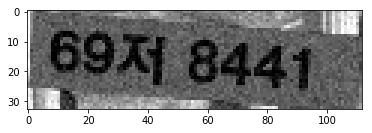

0
['6', '9', '저', '3', '4', '4', '1']


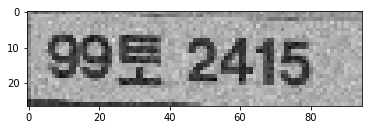

1
['9', '9', '토', '2', '4', '1', '5']


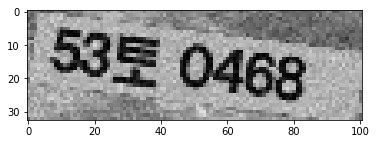

2
['5', '8', '토', '0', '4', '6', '8']


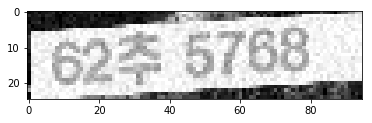

3
['7', '2', '추', '5', '7', '6', '8']


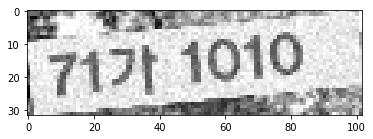

4
['7', '1', '거', '1', '0', '1', '0']


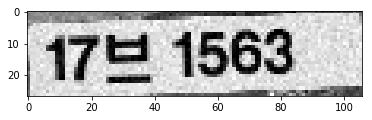

5
['1', '7', '브', '1', '6', '6', '3']


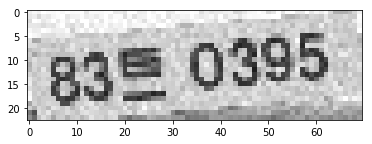

6
['8', '3', '트', '0', '3', '9', '5']


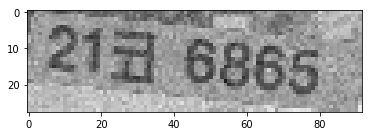

7
['3', '1', '코', '6', '8', '8', '9']


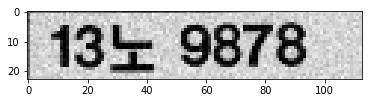

8
['1', '7', '노', '9', '8', '7', '8']


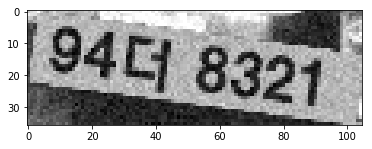

9
['9', '4', '터', '6', '3', '2', '2']


In [33]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    input = {
      'instances': val_img_np.reshape([1,128,64,1])/255.
    }
    prediction = predictor.predict(input)
    plt.imshow(val_img)
    plt.show()
    print(i)
    digits = [JOIN[np.argmax(prediction['predictions'][0]['d1'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d2'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d3'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d4'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d5'])],  
              JOIN[np.argmax(prediction['predictions'][0]['d6'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d7'])]]
    print(digits)

## Endpoint API test

* You may invoke SageMaker endpoint from business application as below:

In [67]:
import boto3
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
runtime = boto3.Session().client('runtime.sagemaker')
tf_endpoint = predictor.endpoint

In [101]:
api_predictor = RealTimePredictor(endpoint=tf_endpoint, sagemaker_session=sess, serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON, accept=CONTENT_TYPE_CSV)
api_response = json.loads(api_predictor.predict(input))
print(JOIN[np.argmax(api_response['predictions'][0]['d1'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d2'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d3'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d4'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d5'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d6'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d7'])] )

94터6322


## Delete Endpoint

In [103]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-scriptmode-2019-03-09-00-23-00-877
